This file is part of a program that is used to develop an objective way to
segment the fetus from ultrasound images, and to analyse the effectiveness of 
using the resulting mask to produce an unobstructed visualisation of the fetus.
The research is organised in three phases: (1) noise reduction filters, 
(2a) heuristic segmentation models, (2b) deep learning segmentation
approach (U-net), and (3) the volume visualisation. The program is developed
for the master Computational Science at the UvA from February to November 2020.

This file contains code for the methodology of phase2a. <br>
You can run this file to plot the intermediate results of the heuristic segmentation models.

Made by Romy Meester


In [1]:
import os
import pydicom
import pickle
import random
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
from jupyterthemes import jtplot

In [2]:
jtplot.style(context='paper', fscale=1.6, ticks=True, grid=False)

In [3]:
# Constants
key = 'dataset1'
DATA_PATH = '../datasets/'
RESULTS_PATH = 'results_method'
RESULTS_IMG_PATH = os.path.join(RESULTS_PATH, 'results_phase2a') 

In [4]:
def create_dir(PATH):
    """ Create a directory. """
    try:
        os.mkdir(PATH)
        print('Directory', PATH, 'created' )
    except FileExistsError:
        print('Directory', PATH, 'already exists' )

# create results folder
create_dir(RESULTS_PATH)

# create results folder for the images
create_dir(RESULTS_IMG_PATH)

Directory results_method already exists
Directory results_method\results_phase2a created


# Helper-functions

In [5]:
def calc_dice_coef(y_true, y_pred):
    """ Calculate the dice similarity coefficient. """
    smooth = 1.0
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = 2. * np.sum(y_true_f * y_pred_f) + smooth
    union = np.sum(y_true_f) + np.sum(y_pred_f) + smooth
    dice = intersection/union

    return dice

def sitk_show(img, key, titlename=None, seeds=None, margin=0.05, dpi=40 ):
    """ Plot and save the sitk images. """
    # plot image
    try:
        plt.imshow(sitk.GetArrayViewFromImage(img), cmap='gray')
    except: 
         plt.imshow(img, cmap='gray')
       
    # show seeds
    if seeds: 
        x_val = [x[0] for x in seeds]
        y_val = [x[1] for x in seeds]
        plt.scatter(x_val, y_val, c='red', s=200)
        
    # show and save image
    if titlename:
        print(titlename)         
        plt.axis('off')
        plt.tight_layout()
        plotname = key + "_" + titlename
        plt.savefig(RESULTS_IMG_PATH + '/' + plotname + '.png')
       
    plt.show()

# Dataset 

In [6]:
pathDicomOrg = DATA_PATH + key + "/crop_org"
pathDicomGT = DATA_PATH + key + "/crop_gt"

def load_scans_sitk(pathDicom):
    reader = sitk.ImageSeriesReader()
    filenamesDICOM = reader.GetGDCMSeriesFileNames(pathDicom)
    reader.SetFileNames(filenamesDICOM)
    img = reader.Execute()
    return img

imgOrg = load_scans_sitk(pathDicomOrg)
imgGT = load_scans_sitk(pathDicomGT)

# Semi-automatic segmentation

all labels [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
selected labels [9, 7, 15, 21, 13]
dice 0.9298360378566166
size (151, 115, 141)
z 76 / 151
A


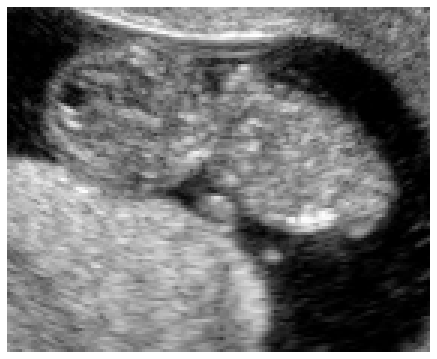

B


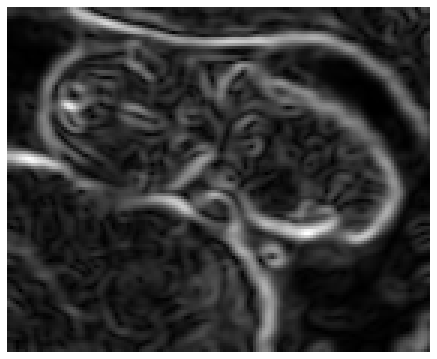

C


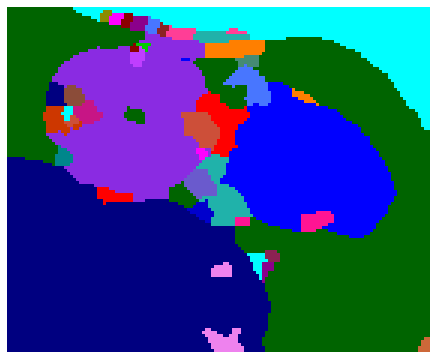

D


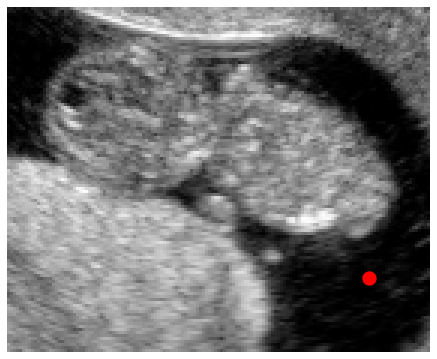

E


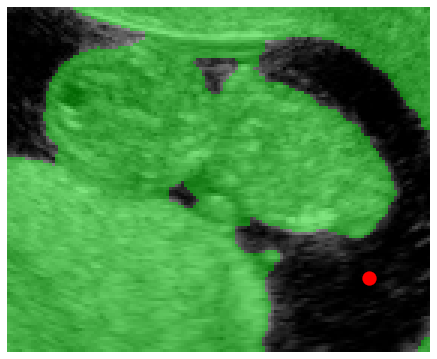

F


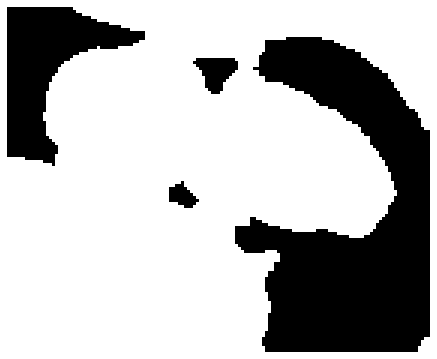

G


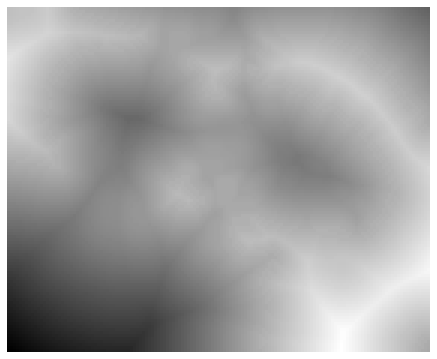

H


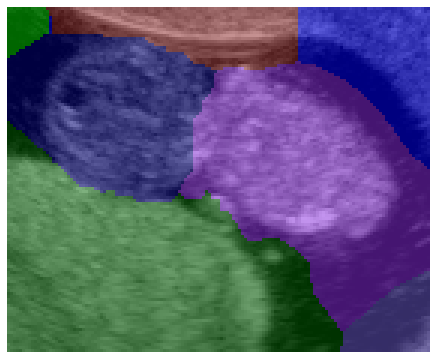

I


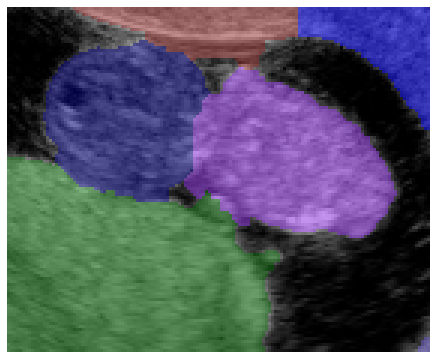

J


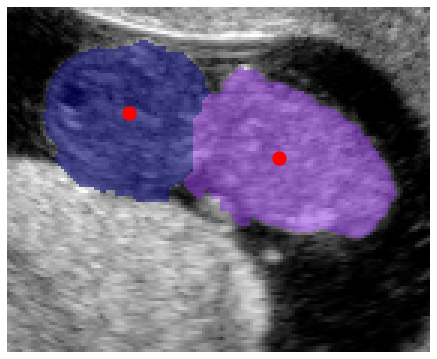

New image of keys: [9, 7, 15, 21, 13]
K


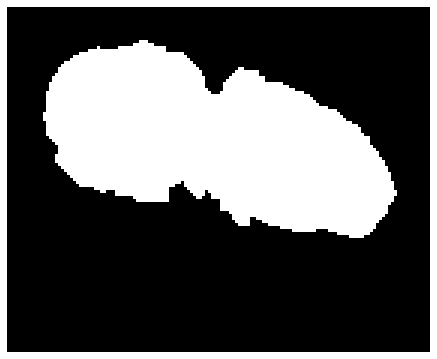

L


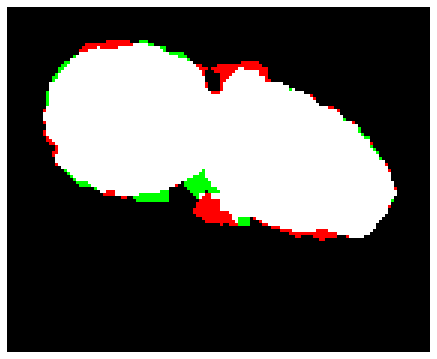

In [7]:
def get_labelvalues(img, seeds):
    """ Get the label values based on the given seed points. """
    array = sitk.GetArrayFromImage(img)
    newseeds = [list(s) for s in seeds]

    results = []
    for seed in newseeds:
        r = array[seed[0], seed[1], seed[2]]
        results.append(r)

    return results

def show_region(images, keys):
    """ Only show the specified regions in the image. """
    images = sitk.GetArrayFromImage(images)
    mask = np.zeros([images.shape[0], images.shape[1], images.shape[2]])
    
    for key in keys:
        # boolean whether image contains the key
        compare = images[:,:,:] == key
        mask[compare] = key
        
    return sitk.GetImageFromArray(mask)

def create_mask(images, keys):
    """ Create a binary image mask based on the key labels. """
    images = sitk.GetArrayFromImage(images)
    mask = np.zeros([images.shape[0], images.shape[1], images.shape[2]])

    for key in keys:
        # boolean whether image contains the key
        compare = images[:,:,:] == key
        mask[compare] = 1

    # reshape the image in correct format
    mask.reshape([images.shape[2], images.shape[1], images.shape[0]])

    return np.array(mask, np.uint8)
       
    
def define_seedpoints(key):
    """ Define the manual seed points corresponding to the dataset key. """
    seedpoints = {}

    if key == 'dataset1':
        seedpoints['component'] = (120,90,70)
        seedpoints['labels'] = [(70,35,40), (70, 50,90), (138,75,80),(144,80,60), (120,70,120)]
    elif key == 'dataset2':
        seedpoints['component'] = (100,70,70)
        seedpoints['labels'] = [(75, 40,50), (70, 40, 95), (75,15,70), (50,55,125)]
    elif key == 'dataset3':
        seedpoints['component'] = (130,70,80)
        seedpoints['labels'] = [(80,55,40), (80,60,90), (40,120,125), (50,110,90)]
    elif key == 'dataset4':
        seedpoints['component'] = (50,80,65)
        seedpoints['labels'] = [(65,40,40), (65,60,100), (50,60,60)]
    elif key == 'dataset5':
        seedpoints['component'] = (150,20,90)
        seedpoints['labels'] = [(90,60,50), (90,80,130), (110,90,120), (130, 95,100)]
    elif key == 'dataset6':
        seedpoints['component'] = (110,100,70)
        seedpoints['labels'] = [(70,40,40), (70,60,90), (90,75,115),(110,80,80)]
    elif key == 'dataset7':
        seedpoints['component'] = (30,80,90)
        seedpoints['labels'] = [(90,80,125), (90,50,60), (90,120,80),  (90,90,90), (100,110,125)]
    else:
        print('No seed points specified for this dataset.')

    return seedpoints

def get_all(img):
    """ Get all the labels. """
    array = sitk.GetArrayFromImage(img)
    return list(np.unique(array))

def create_colors(frame_gt, frame_prediction):
    """ Create colored predicted image by comparing the prediction
    to the ground truth. True positives are white, false positives green, 
    and false negatives red. """
    
    frame_result = np.zeros((frame_prediction.shape[0],frame_prediction.shape[1], 
                             frame_prediction.shape[2] ,3), dtype=np.uint8) # black: true negatives
    frame_result[frame_prediction == 1] = [255, 255, 255] # white: true positives

    frame_result[(frame_prediction == 1) & (frame_gt == 0)] = [0, 255, 0] # green: false positives
    frame_result[(frame_prediction == 0) & (frame_gt == 1)] = [255, 0, 0] # red: false negatives

    return frame_result
  

def calc_ws_semiauto(img, img_gt, key, sigma=1.5, level1=4, level2=1, showing=False):
    """ Semi automatic with specified seed points for each dataset.
        The seed points define which labels needs to be merged for the binary mask. """
    
    # size 
    image = sitk.GetArrayFromImage(img)
    image_size = image.shape
    z = round(image_size[0] / 2.)
    
    # get the manually selected seedpoints
    seedpoints = define_seedpoints(key)
    seed_component = seedpoints['component']
    seeds_labels = seedpoints['labels']

    # calculate the semi-automatic watershed segmentation
    feature_img = sitk.GradientMagnitudeRecursiveGaussian(img, sigma=sigma)
    ws_img = sitk.MorphologicalWatershed(feature_img, level=level1, markWatershedLine=False, fullyConnected=False)
    seg = sitk.ConnectedComponent(ws_img!=ws_img[seed_component[0],seed_component[1],seed_component[2]])
    filled = sitk.BinaryFillhole(seg!=0)
    d = sitk.SignedMaurerDistanceMap(filled, insideIsPositive=False, squaredDistance=False, useImageSpacing=False)
    ws_img2 = sitk.MorphologicalWatershed( d, markWatershedLine=False, level=level2)
    ws = sitk.Mask(ws_img2, sitk.Cast(seg, ws_img2.GetPixelID()))

    # create the final binary mask based on label keys
    labels = get_labelvalues(ws, seeds_labels)
    all_labels = get_all(ws)
    print('all labels', all_labels)
    print('selected labels', labels)
    regions = show_region(ws, keys=labels) 
    ws_labels = sitk.Mask(ws_img2, sitk.Cast(regions, ws_img2.GetPixelID()))
    result_ws_semi = create_mask(ws, keys=labels)
    
    img_gt = sitk.GetArrayFromImage(img_gt)
    colored_resultingmask = create_colors(img_gt, result_ws_semi)
    dice = calc_dice_coef(img_gt , result_ws_semi)
    print('dice', dice)
    
    # show and save the images
    if showing == True:
        print('size', image_size)
        print('z', z , '/', image_size[0])
        sitk_show(img[:,:,z], 'semiautows_' + str(key), 'A') # A: origial image
        sitk_show(feature_img[:,:,z], 'semiautows_' + str(key), 'B') # B: gradient
        sitk_show(sitk.LabelToRGB(ws_img[:,:,z]), 'semiautows_' + str(key), 'C') # C: watershed
        sitk_show(img[:,:,z], 'semiautows_' + str(key), 'D', seeds=[seed_component]) # D: seed point
        sitk_show(sitk.LabelOverlay(img[:,:,z], seg[:,:,z]), 'semiautows_' + str(key), 'E', seeds=[seed_component]) # E: connected foreground components
        sitk_show(filled[:,:,z], 'semiautows_' + str(key), 'F') # F: binary fill hole 
        sitk_show(d[:,:,z], 'semiautows_' + str(key), 'G') # G: distance map
        sitk_show(sitk.LabelOverlay(img[:,:,z], ws_img2[:,:,z]), 'semiautows_' + str(key), 'H') # H: watershed
        sitk_show(sitk.LabelOverlay(img[:,:,z], ws[:,:,z]), 'semiautows_' + str(key), 'I') # I: labeled mask
        sitk_show(sitk.LabelOverlay(img[:,:,z], ws_labels[:,:,z]), 'semiautows_' + str(key), 'J', seeds=[(40, 35, 70), (90, 50, 70)]) #J: define regions
        print('New image of keys: ' + str(labels))
        sitk_show(result_ws_semi[z], 'semiautows_' + str(key), 'K') # K: resulting mask 
        sitk_show(colored_resultingmask[z], 'semiautows_' + str(key), 'L') #L: colored resulting mask 
    
    return result_ws_semi

img_ws = calc_ws_semiauto(imgOrg, imgGT, key, sigma=1.5, level1=4, level2=1, showing=True)

# Fully automatic segmentation

Start searching for seed point
possible seed point (98, 97)
possible seed point (60, 75)
possible seed point (20, 62)
possible seed point (118, 78)
possible seed point (121, 34)
seedpoint (121, 34)
A


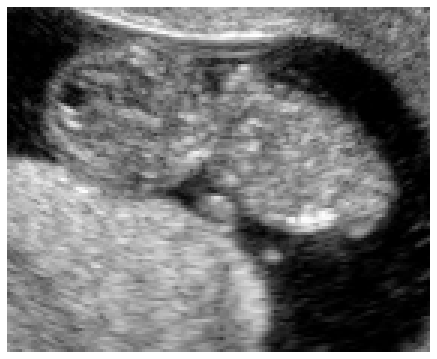

B


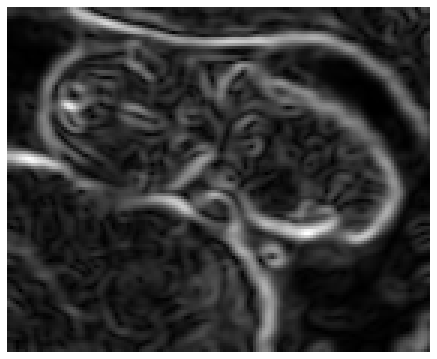

C


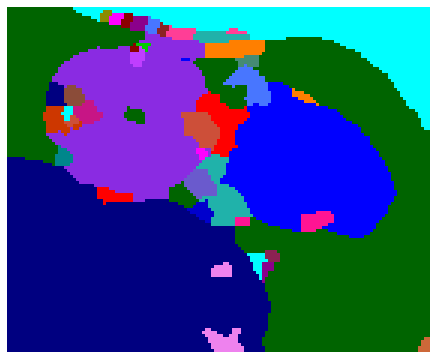

D


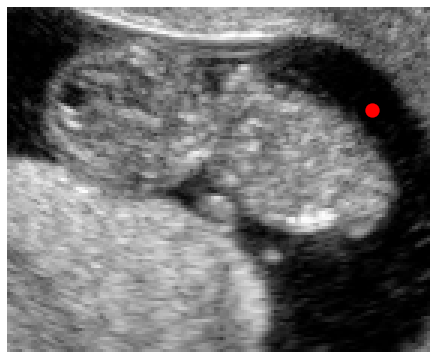

E


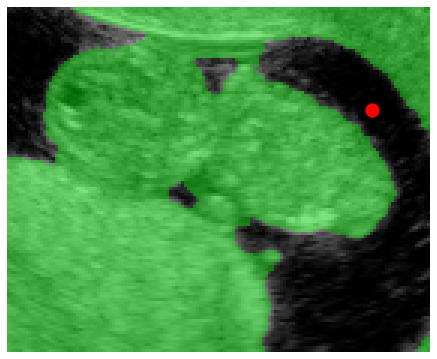

F


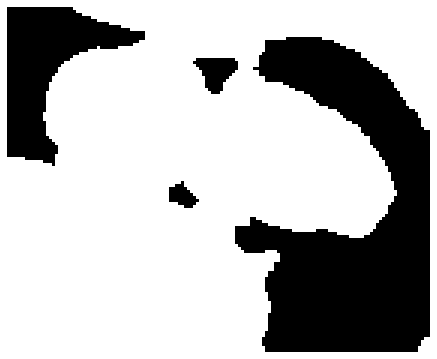

G


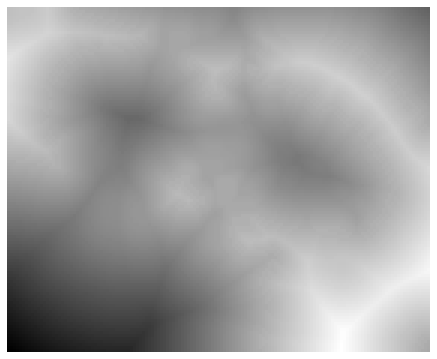

H


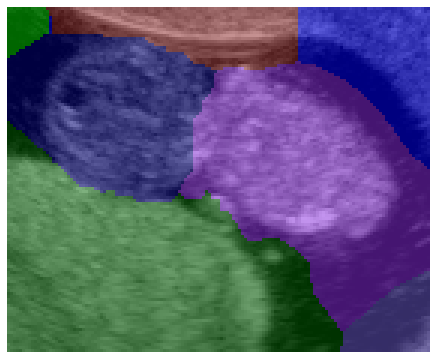

I


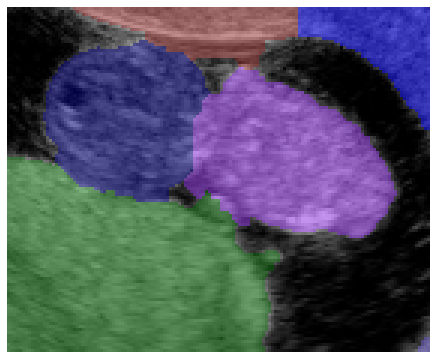

new image of keys: [5, 7, 9, 10, 12, 13, 14, 15]
J


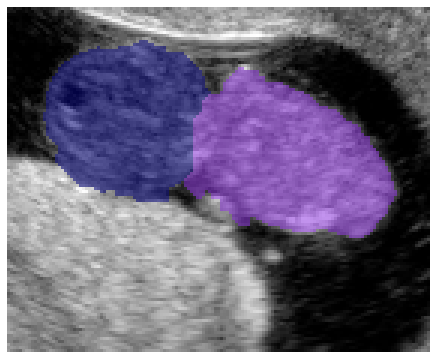

K


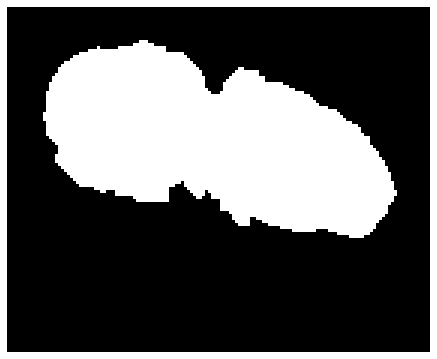

L


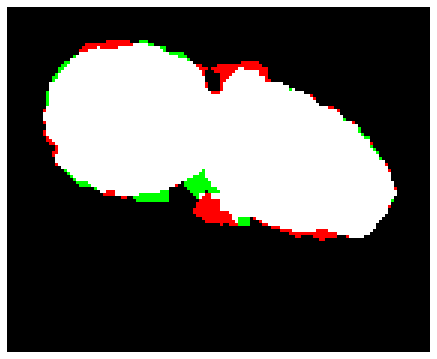

In [8]:
def calculate_values(image, center):
    """ Return the total number of pixel intensity of the centered pixel
    and the corresponding neighbor values divided by 9 (the amount of pixels). """
    # total number of pixel intensity
    values = 0

    values += image[center[1]-1][center[0]-1] # left top
    values += image[center[1]-1][center[0]]   # left middle
    values += image[center[1]-1][center[0]+1] # left bottom
    values += image[center[1]][center[0]-1]   # middle top
    values += image[center[1]][center[0]]     # center
    values += image[center[1]][center[0]+1]   # middle bottom
    values += image[center[1]+1][center[0]-1] # right top
    values += image[center[1]+1][center[0]]   # right middle
    values += image[center[1]+1][center[0]+1] # right bottom

    # the mean value intensity
    values = round(values / 9.)
    return values

def possible_seed(image, count):
    """ Generate a random possible seed.
        Which is not at a boundary of the image. """
    searchseed = True

    while searchseed:
        # make random simulation repeatable with counter
        random.seed(count * 3)

        # define x and y
        x = random.randint(0, image.shape[1]-1)
        y = random.randint(0, image.shape[0]-1)

        # check if seed is in boundary
        if (x != 0) and (y != 0) and (x != image.shape[1]-1) and (y != image.shape[0]-1):
            searchseed = False

    print('possible seed point', (x,y))
    return (x,y)

def compute_seed1(image):
    """ Apply method of which the idea is based on the hit-or-miss Monte Carlo method.
        Pick randomly an pixel in the image.
        Check its neighbours with a kernel size of 3.
        When the total values < threshold: seed point is found. (Hit)
        Otherwise, continue searching (Miss)
    """

    seedfound = False       # true when seedpoint is found
    value_threshold = 10    # the percentage of values including neighbours which needs to be black(ish)
    count = 0               # make random simulation repeatable with counter

    print('Start searching for seed point') # hitmis
    while seedfound == False:
        center = possible_seed(image, count)

        # check the values of the center and neighbors
        values = calculate_values(image, center)

        if values < value_threshold:
            # seedpoint is found
            seedfound = True
            print('seedpoint', center)
        else:
            count += 1

    return center

def generate_seed1(img):
    """ Compute the first seed point for generating the connected component.
    This seed point and its neighbours ."""

    # take in the middle of the whole 3D image the 2D slice
    # to decrease the computational time
    # Pay attention: sitk (x,y,z) makes numpy actually (z,y,x)
    size = img.GetSize()
    images = sitk.GetArrayFromImage(img)
    z = round(size[2] / 2.)
    slice = images[z,:,:]

    # make seedpoint
    seed = compute_seed1(slice)
    real_seed = (seed[0], seed[1], z)
    return real_seed

def get_labels_auto(image):
    """ Get all the existing labels for the fully automatic segmentation. """
    img = sitk.GetArrayFromImage(image)
    img = img.flatten()
    labels = []

    # traverse for all elements
    for x in img:
        # check if exists in unique_list or not
        if x not in labels:
            labels.append(x)
            
    return sorted(labels)

def define_labels_auto(image, all_labels):
    """ Define the labels which are not in the boundaries of the image. """
    img = sitk.GetArrayFromImage(image)

    # create the boundaries
    boundaries = []
    boundaries += img[0].tolist() + img[-1].tolist()

    for el in img:
        for small in el:
            boundaries += [small[0]] + [small[-1]]
        boundaries += el[0].tolist() + el[-1].tolist()

    # merge the lists to one list
    merged_boundaries = []
    for bound in boundaries:
        if isinstance(bound, list):
            for x in bound:
                merged_boundaries.append(x)
        else:
            number = int(bound)
            merged_boundaries.append(number)

    # get the unique boundary labels
    bound_labels = sorted(list(set(merged_boundaries)))

    # compare label lists and return the labels which are not in boundary
    result = list(set(bound_labels)^set(all_labels))
  
    return result

def show_region(images, keys):
    """ Only show the specified regions in the image. """
    images = sitk.GetArrayFromImage(images)
    mask = np.zeros([images.shape[0], images.shape[1], images.shape[2]])
    
    for key in keys:
        # boolean whether image contains the key
        compare = images[:,:,:] == key
        mask[compare] = key
        
    return sitk.GetImageFromArray(mask)

def create_colors(frame_gt, frame_prediction):
    """ Create colored predicted image by comparing the prediction
    to the ground truth. True positives are white, false positives green, 
    and false negatives red. """
    
    frame_result = np.zeros((frame_prediction.shape[0],frame_prediction.shape[1], 
                             frame_prediction.shape[2] ,3), dtype=np.uint8) # black: true negatives
    frame_result[frame_prediction == 1] = [255, 255, 255] # white: true positives

    frame_result[(frame_prediction == 1) & (frame_gt == 0)] = [0, 255, 0] # green: false positives
    frame_result[(frame_prediction == 0) & (frame_gt == 1)] = [255, 0, 0] # red: false negatives

    return frame_result

def calc_ws_fullyauto(img, img_gt, key, sigma=1.5, level1=4, level2=1, showing=False):
    """ Automatic watershed segmentation to create a binary mask."""

    # the 2D slice in the middle of the image    
    image = sitk.GetArrayFromImage(img)
    image_size = image.shape
    z = round(image_size[0] / 2.)

    # calculate watershed
    feature_img = sitk.GradientMagnitudeRecursiveGaussian(img, sigma=sigma)
    ws_img = sitk.MorphologicalWatershed(feature_img, level=level1, markWatershedLine=False, fullyConnected=False)
    seed1 = generate_seed1(img) 
    seg2 = sitk.ConnectedComponent(ws_img!=ws_img[seed1[0], seed1[1], seed1[2]])
    filled = sitk.BinaryFillhole(seg2!=0)
    d = sitk.SignedMaurerDistanceMap(filled, insideIsPositive=False, squaredDistance=False, useImageSpacing=False)
    ws_img2 = sitk.MorphologicalWatershed( d, markWatershedLine=False, level=level2)
    ws = sitk.Mask( ws_img2, sitk.Cast(seg2, ws_img2.GetPixelID()))
    labels = get_labels_auto(ws)
    use_labels = define_labels_auto(ws, labels)
    regions = show_region(ws, keys=use_labels) 
    ws_labels = sitk.Mask(ws_img2, sitk.Cast(regions, ws_img2.GetPixelID()))
    result_ws_auto = create_mask(ws, keys=use_labels) 
    img_gt = sitk.GetArrayFromImage(img_gt)
    colored_resultingmask = create_colors(img_gt, result_ws_auto)

    if showing == True:
        sitk_show(img[:,:,z], 'fullyautows_' + str(key), 'A')   # A: origial image
        sitk_show(feature_img[:,:,z], 'fullyautows_' + str(key), 'B')  # B: gradient
        sitk_show(sitk.LabelToRGB(ws_img[:,:,z]), 'fullyautows_' + str(key), 'C')  # C: watershed
        sitk_show(img[:,:,z], 'fullyautows_' + str(key), 'D', seeds=[(seed1[0], seed1[1], seed1[2])])  # D: seed point
        sitk_show(sitk.LabelOverlay(img[:,:,seed1[2]], seg2[:,:,seed1[2]]),  'fullyautows_' + str(key), 'E', seeds=[(seed1[0], seed1[1], seed1[2])])   # E: connected foreground components
        sitk_show(filled[:,:,z], 'fullyautows_' + str(key), 'F')     # F: binary fill hole 
        sitk_show(d[:,:,z], 'fullyautows_' + str(key), 'G')  # G: distance map
        sitk_show(sitk.LabelOverlay(img[:,:,z], ws_img2[:,:,z]), 'fullyautows_' + str(key), 'H') # H: watershed
        sitk_show(sitk.LabelOverlay(img[:,:,z], ws[:,:,z]), 'fullyautows_' + str(key), 'I')  # I: labeled mask
        print('new image of keys: ' + str(use_labels))
        sitk_show(sitk.LabelOverlay(img[:,:,z], ws_labels[:,:,z]), 'fullyautows_' + str(key), 'J') #J: define regions
        sitk_show(result_ws_auto[z], 'fullyautows_' + str(key), 'K')   # K: resulting mask 
        sitk_show(colored_resultingmask[z], 'fullyautows_' + str(key), 'L') #L: colored resulting mask 

    return result_ws_auto

img_ws = calc_ws_fullyauto(imgOrg, imgGT, key, sigma=1.5, level1=4, level2=1, showing=True)